In [111]:
from functions import regress
from functions import summarize
import pandas as pd

ImportError: cannot import name 'summarize' from 'functions' (/home/ygael/Projects/consumer analysis/code/functions.py)

In [9]:
gss = pd.io.stata.read_stata('../data/GSS1996.dta', convert_categoricals=False)
gss.to_csv('../data/gss_converted.csv')

In [14]:
varlist=list(gss)

In [22]:
carlist=[]
for item in varlist:
    if item[0:3]=="car":
     carlist.append(item)

In [26]:
#Drop all instances where no vehicle was purchased
gss=gss.dropna(subset=["carprivt"])

In [30]:
def summarize(dataset,variable):
    data/=dataset[variable]
    varname=variable
    obs=len(dataset[variable])
    mean=mean(data)

In [ ]:
Variable Obs Mean Std. Dev. Min Max
mpg 74 21.2973 5.785503 12 41
We see that we have 74 observations. The mean of mpg is 21.3 miles per gallon, and the standard

In [79]:
tester=gss['carprivt']

In [31]:
summarize(gss,carprivt)

NameError: name 'carprivt' is not defined

In [107]:
def summarize(*args):
    #define arguments
    dataframe=args[0]
    variable= args[1]
    dfvar=dataframe[variable]
    obs=len(dfvar)
    maxvalue=max(dfvar)
    minvalue=min(dfvar)
    Q1=dfvar.quantile(q=0.25)
    Q2=dfvar.quantile(q=0.5)
    Q3=dfvar.quantile(q=0.75)
    mean=dfvar.mean()
    std=dfvar.std()

    summary=pd.DataFrame({'Obs' : [obs], "Max" : [maxvalue], "Min" : [minvalue], "Q1" : [Q1], "Median" : [Q2], "Q3" : [Q3], "Mean" : [mean], "Std" : [std]})
    print(summary)
    print("\n")
    hist=plt.hist(dfvar)
    print(hist)


   Obs  Max  Min   Q1  Median   Q3      Mean       Std
0  735  2.0  1.0  1.0     2.0  2.0  1.659864  0.474077


(array([250.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 485.]), array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]), <BarContainer object of 10 artists>)


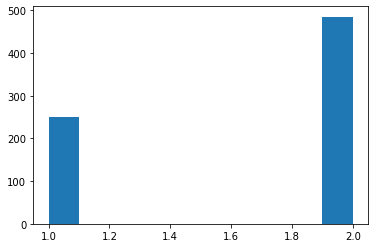

In [108]:
summarize(gss, "carprivt")